In [ ]:
from keras.models import Sequential

In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [ ]:
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
#from keras.optimizers import  RMSprop, adam
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from keras.utils import np_utils
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
from numpy import *
from PIL import Image
import theano
from tqdm import tqdm 
from skimage import io

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8319771426771920331
xla_global_id: -1
]


In [ ]:
val_path=r'/content/drive/MyDrive/Osteoarthritis_Assignment_dataset/Valid'
test_path=r'/content/drive/MyDrive/Osteoarthritis_Assignment_dataset/test'
train_path=r'/content/drive/MyDrive/Osteoarthritis_Assignment_dataset/train'

In [ ]:
x_train=[]
for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(80,80))
        x_train.append(img_arr)
x_test=[]
for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(80,80))
        x_test.append(img_arr)
x_val=[]
for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(80,80))
        x_val.append(img_arr)

In [ ]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [ ]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_path,
                                                target_size = (80, 80),
                                                batch_size = 16,
                                                class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (80, 80),
                                            batch_size = 16,
                                            class_mode = 'categorical')
val_set = val_datagen.flow_from_directory(val_path,
                                        target_size = (80, 80),
                                        batch_size = 16,
                                        class_mode = 'categorical')

Found 2350 images belonging to 2 classes.
Found 845 images belonging to 2 classes.
Found 641 images belonging to 2 classes.


In [ ]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [ ]:
training_set.class_indices

{'Normal': 0, 'Osteoarthritis': 1}

In [ ]:
train_y.shape,test_y.shape,val_y.shape

((2350,), (845,), (641,))

In [ ]:
from tensorflow.keras.applications import DenseNet201
dense_net = DenseNet201(input_shape = (80, 80, 3), weights='imagenet', include_top=False)

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
for layer in dense_net.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(dense_net.output)

In [ ]:
from tensorflow.keras.models import Model
x = Dropout(0.5)(x)
prediction = Dense(2, activation='sigmoid')(x)

model = Model(inputs=dense_net.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 86, 86, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 40, 40, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 40, 40, 64)   256         ['conv1/conv[0][0]']             
                                                                                              

In [ ]:
model.compile(
 loss='sparse_categorical_crossentropy',
 optimizer="adam",
 metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
checkpoint = ModelCheckpoint('./Osteoarthritis_Assignment_dataset/DenseNet Model/weights-imporvement-{epoch:02d}-{val_accuracy:.2f}.hdf5',
                            monitor = 'val_accuracy', save_best_only = True, verbose = 1)
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience=5)
#Early stopping to avoid overfitting of model
log_csv = CSVLogger('./Osteoarthritis_Assignment_dataset/DenseNet Model/my_log.csv', separator=',', append = False)

In [ ]:
history = model.fit(
 train_x,
 train_y,
 validation_data=(val_x,val_y),
 epochs=50,
 callbacks=[checkpoint, log_csv],
 batch_size=16,shuffle=True)

Epoch 1/50
147/147 [==============================] - ETA: 0s - loss: 1.1966 - accuracy: 0.6868
Epoch 1: val_accuracy improved from -inf to 0.42590, saving model to ./Osteoarthritis_Assignment_dataset/DenseNet Model/weights-imporvement-01-0.43.hdf5
147/147 [==============================] - 101s 616ms/step - loss: 1.1966 - accuracy: 0.6868 - val_loss: 1.8301 - val_accuracy: 0.4259
Epoch 2/50
147/147 [==============================] - ETA: 0s - loss: 1.0236 - accuracy: 0.7217
Epoch 2: val_accuracy improved from 0.42590 to 0.46178, saving model to ./Osteoarthritis_Assignment_dataset/DenseNet Model/weights-imporvement-02-0.46.hdf5
147/147 [==============================] - 88s 601ms/step - loss: 1.0236 - accuracy: 0.7217 - val_loss: 2.6860 - val_accuracy: 0.4618
Epoch 3/50
147/147 [==============================] - ETA: 0s - loss: 0.9546 - accuracy: 0.7319
Epoch 3: val_accuracy improved from 0.46178 to 0.59438, saving model to ./Osteoarthritis_Assignment_dataset/DenseNet Model/weights-imp

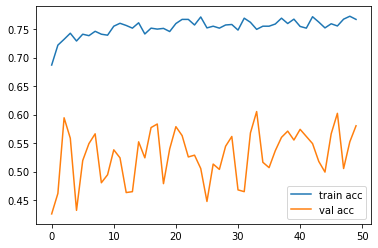

In [37]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('dense_net-acc-rps-1.png')
plt.show()

In [46]:
print("[Loss, Accuracy] = ", model.evaluate(test_x,test_y,batch_size=16))

53/53 [==============================] - 30s 458ms/step - loss: 4.4390 - accuracy: 0.4118
[Loss, Accuracy] =  [4.439021587371826, 0.41183432936668396]


In [53]:
model.save('../Osteoarthritis_Assignment_dataset/DenseNet Model/dense_net_model.h5')

In [56]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.39      0.60      0.47       372
           1       0.46      0.27      0.34       473

    accuracy                           0.41       845
   macro avg       0.42      0.43      0.40       845
weighted avg       0.43      0.41      0.40       845



In [59]:
print(confusion_matrix(y_pred,test_y))

[[222 150]
 [347 126]]
